In [1]:
import pandas as pd

class Paths:
    train_path = "../Lab3/data/Train.csv"
    val_path = "../Lab3/data/Val.csv"
    test_path = "../Lab3/data/Test.csv"

path = Paths()

train_data = pd.read_csv(path.train_path)
val_data = pd.read_csv(path.val_path)
test_data = pd.read_csv(path.test_path)

In [2]:
data = pd.concat([train_data, val_data], ignore_index=True)
X = data.drop(['Yield'], axis=1)
y = data['Yield']

Выполним первоначальный корреляционный анализ (мы его сделали еще в прошлой лабораторной работе) и откинули признаки с взаимной корелляцией >= 0.7

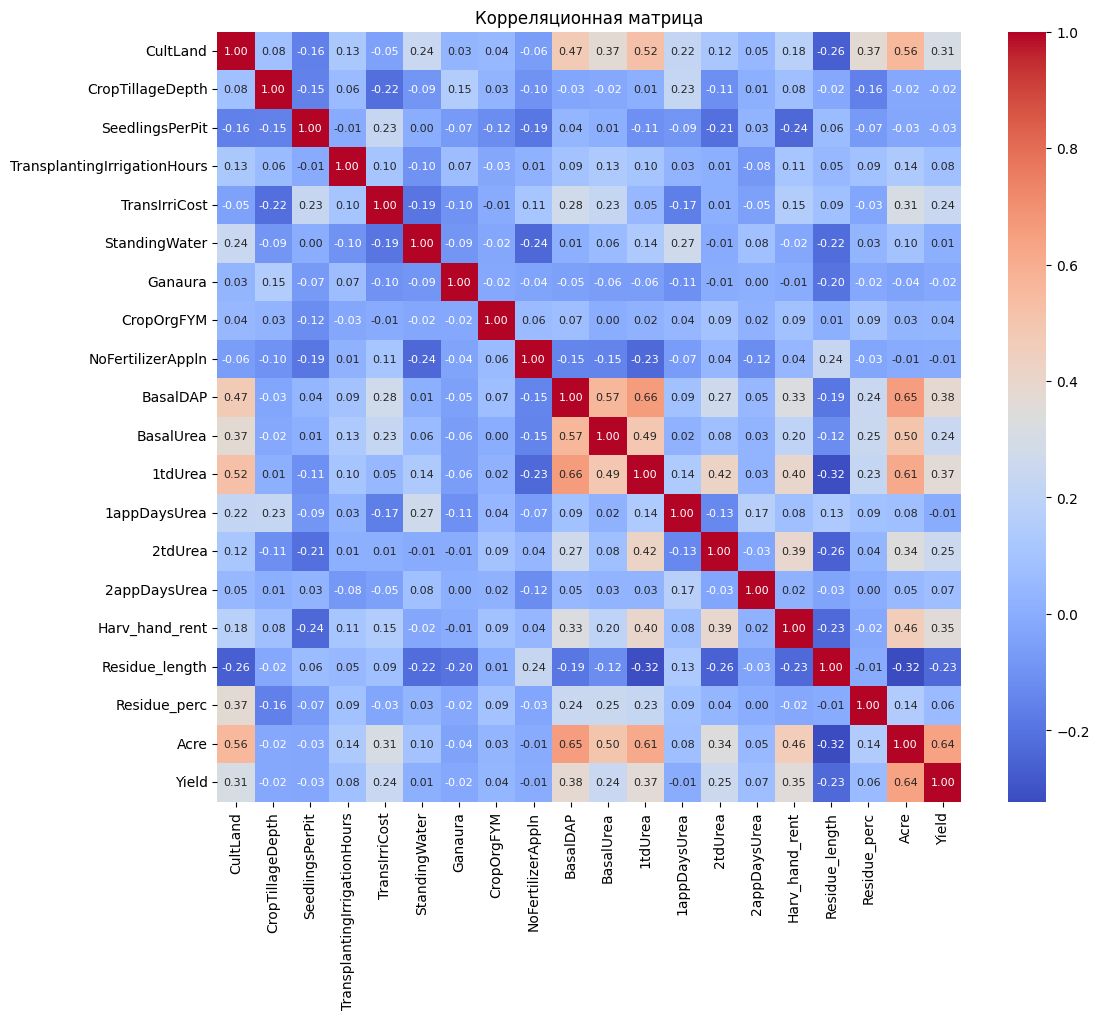

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = data.corr()

plt.figure(figsize=(12, 10)) 
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    annot_kws={"size": 8}  
)
plt.title("Корреляционная матрица")
plt.show()

Начинаем догадываться, в чем "интересность" этого набора данных.  
Acre сильно влияет на Yield (таргет)

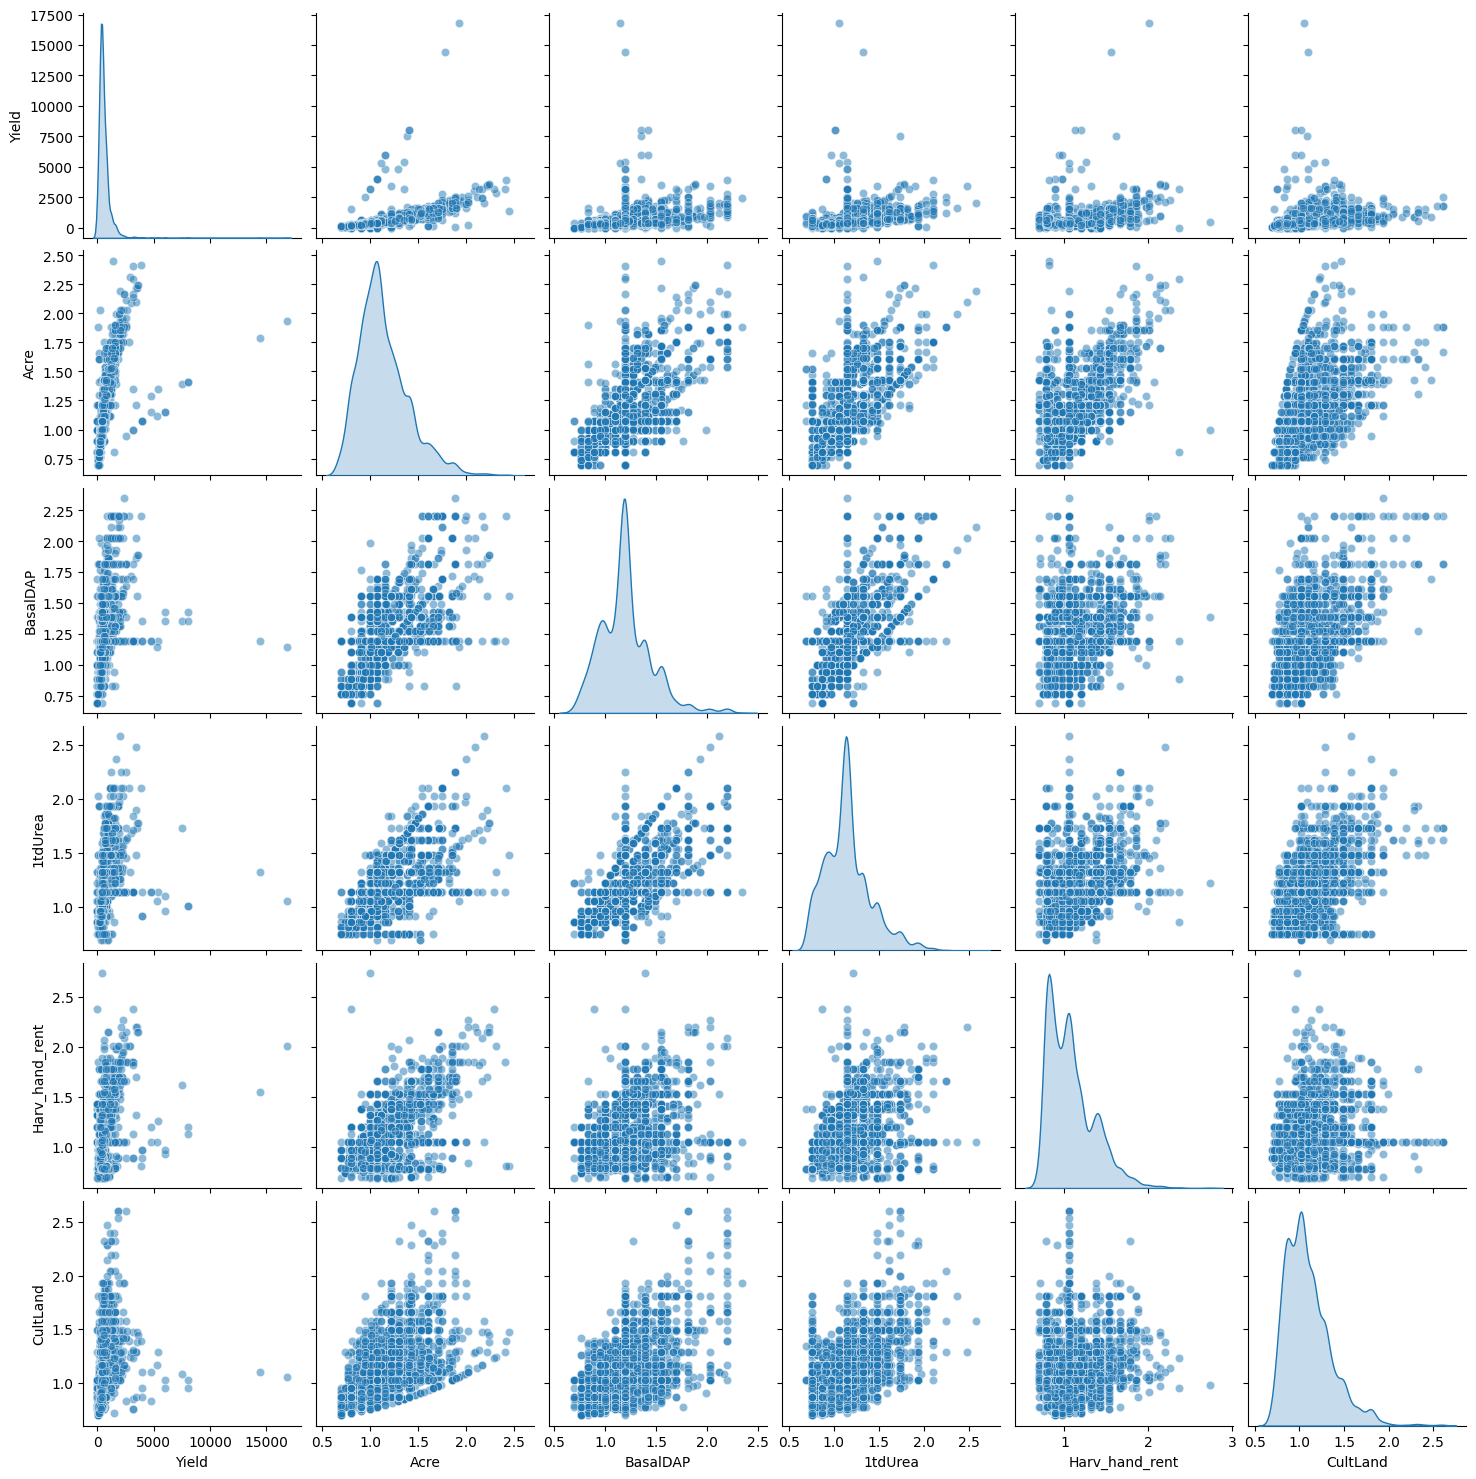

In [4]:
# Выбираем признаки с высокой корреляцией с таргетом
high_corr_features = corr_matrix['Yield'].abs().sort_values(ascending=False).head(6).index

selected_data = data[high_corr_features]
sns.pairplot(selected_data, diag_kind="kde", plot_kws={"alpha": 0.5})
plt.show()


Очень интересный график Yield(Acre), что подтверждает предыдущие выводы.

Небольшие выводы на этоп этапе

- Yield и Acre:
Наблюдается положительная корреляция. С увеличением площади (Acre) урожайность (Yield) возрастает. Это логично, так как больше площади может привести к большему урожаю.

- Yield и BasalDAP/1tdUrea:
Эти признаки (вероятно, удобрения) также имеют положительное влияние на урожай. При увеличении уровня внесения данных компонентов урожайность возрастает, хотя зависимость может быть нелинейной.

- Yield и Harv_hand_rent:
Взаимосвязь слабая. Возможно, стоимость ручного труда влияет на урожайность лишь косвенно или связана с другими переменными, такими как технология производства.

- Yield и CultLand:
Положительная связь, что отражает логическую зависимость: больше обрабатываемой земли приводит к большей урожайности.


In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df


,Variable,VIF
0,CultLand,40.634203
1,CropTillageDepth,1.283561
2,SeedlingsPerPit,18.848554
3,TransplantingIrrigationHours,21.050569
4,TransIrriCost,30.271302
5,StandingWater,20.342488
6,Ganaura,14.839342
7,CropOrgFYM,17.974505
8,NoFertilizerAppln,1.340216
9,BasalDAP,62.068723


Видим, что много признаков имеют высокий VIF - то есть имеется серьезная мультиколлиниарность между признаками. Будем исправлять его PCA.

### Генерация интересных фичей

In [6]:
import numpy as np

# Индекс ирригации
X['IrrigationIndex'] = X['TransplantingIrrigationHours'] * X['TransIrriCost']

# Плотность удобрения
X['FertilizerDensity'] = X['BasalUrea'] / X['Acre']

# Плотность ирригации
X['WaterDensity'] = X['StandingWater'] / X['CultLand']

# Бинаризация ирригации
X['HighIrrigationCost'] = (X['TransIrriCost'] > X['TransIrriCost'].mean()).astype(int)

# Взаимодействие между CultLand и CropTillageDepth
X['LandTillageInteraction'] = X['CultLand'] * X['CropTillageDepth']

# Производительность воды и удобрений
X['WaterFertilizerInteraction'] = X['StandingWater'] * X['BasalUrea']

# Логарифмирование для избавления от смещения
X['LogHarvHandRent'] = np.log1p(X['Harv_hand_rent'])


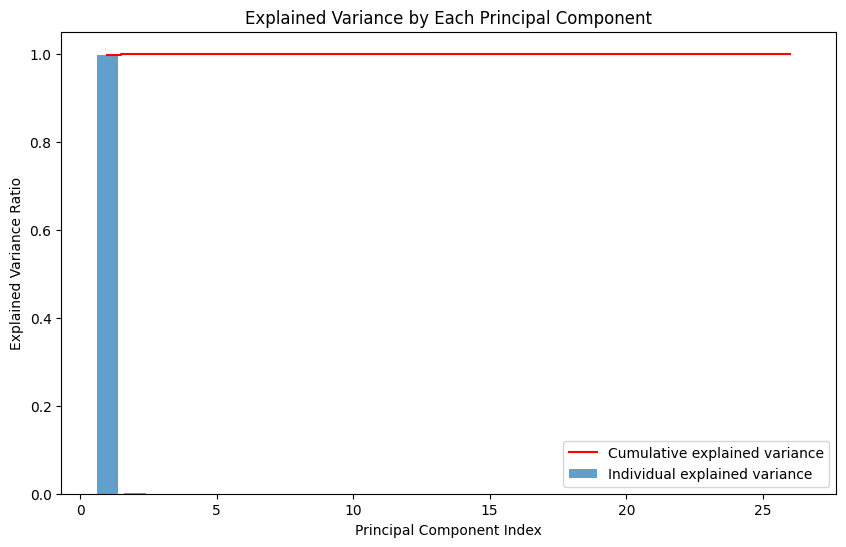

Количество компонент для объяснения 95% дисперсии: 1
Объяснённая дисперсия по компонентам:
PC1: 99.80%


In [7]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Построим график объяснённой дисперсии
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual explained variance')
plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid', label='Cumulative explained variance', color='red')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Each Principal Component')
plt.legend()
plt.show()

n_components = np.argmax(cumulative_variance_ratio >= 0.997) + 1
print(f"Количество компонент для объяснения 95% дисперсии: {n_components}")

# Обучаем PCA с выбранным количеством компонент
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X)

columns = [f"PC{i+1}" for i in range(n_components)]
X_pca_df = pd.DataFrame(X_reduced, columns=columns)

print("Объяснённая дисперсия по компонентам:")
for i, variance in enumerate(explained_variance_ratio[:n_components], 1):
    print(f"PC{i}: {variance:.2%}")

if n_components >= 2:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], alpha=0.7)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Projection onto First Two Principal Components')
    plt.grid()
    plt.show()

Вот оно!

Оказывается, что в реальности, только одна переменная важна =)

Попробуем отобрать признаки с помощью Lasso и проанализировать результаты

Топ-2 значимых признаков:
      Feature  Coefficient
18       Acre  2039.628756
10  BasalUrea  -637.808653


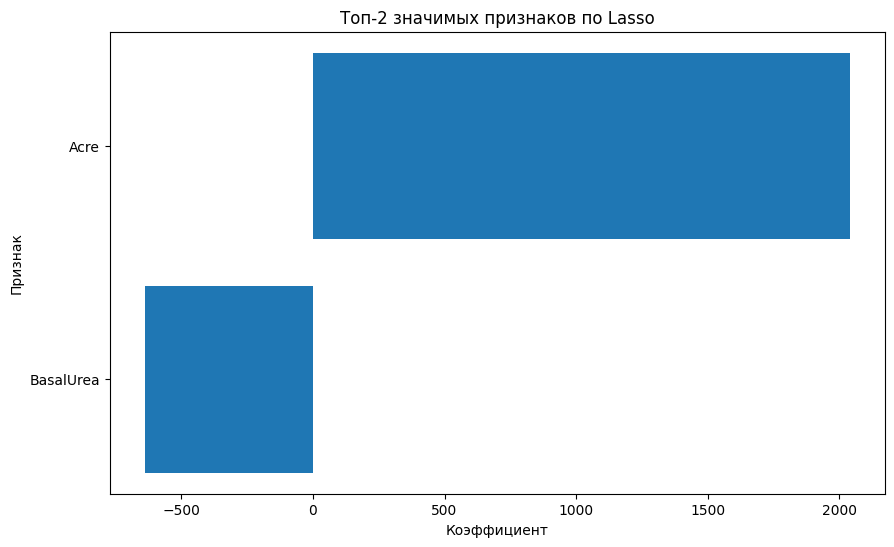

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

lasso = Lasso(alpha=1.)
lasso.fit(X, y)

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})

coefficients['AbsCoefficient'] = coefficients['Coefficient'].abs()
significant_features = coefficients[coefficients['Coefficient'] != 0].sort_values(by='AbsCoefficient', ascending=False)

top_n = 1
top_features = significant_features.head(top_n)

print(f"Топ-{top_n} значимых признаков:")
print(top_features[['Feature', 'Coefficient']])

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.title(f"Топ-{top_n} значимых признаков по Lasso")
plt.xlabel("Коэффициент")
plt.ylabel("Признак")
plt.gca().invert_yaxis() 
plt.show()


Подтвердили полученные ранее результаты

In [9]:
import numpy as np

class LinearRegressionElasticNet:
    def __init__(self, epsilon=1e-6, max_steps=10000, w0=None, b0=None, alpha=1e-5, l1_ratio=0.5, lam=1e-2):
        self.epsilon = epsilon
        self.max_steps = max_steps
        self.w0 = w0
        self.alpha = alpha  
        self.l1_ratio = l1_ratio  
        self.lam = lam  
        self.w = None
        self.b0 = b0
        self.b = None
        
    def fit(self, X, y):
        X = self._scale_features(X)
        y = self._scale_target(y)

        l, d = X.shape

        if self.w0 is None:
            self.w0 = np.zeros(d)
        self.w = self.w0.copy()

        if self.b0 is None:
            self.b0 = 0.0
        self.b = self.b0

        for step in range(self.max_steps):
            y_pred = np.dot(X, self.w) + self.b
            residuals = y_pred - y

            grad_loss_w = (2 / l) * np.dot(X.T, residuals)
            grad_reg_w = self.lam * (self.l1_ratio * np.sign(self.w) + (1 - self.l1_ratio) * self.w)
            gradient_w = grad_loss_w + grad_reg_w
            gradient_w = np.clip(gradient_w, -1e5, 1e5)
            if np.isnan(gradient_w).any():
                raise ValueError("NaN detected in gradients. Try reducing the learning rate.")

            gradient_b = (2 / l) * np.sum(residuals)
            w_new = self.w - self.alpha * gradient_w
            b_new = self.b - self.alpha * gradient_b

            if np.linalg.norm(w_new - self.w) < self.epsilon:
                self.w = w_new
                self.b = b_new
                break
                
            self.w = w_new
            self.b = b_new

        self.X_mean = self.X_mean_
        self.X_std = self.X_std_
        self.y_mean = self.y_mean_
        self.y_std = self.y_std_

        return self
    
    def predict(self, X):
        if self.w is None or self.b is None:
            raise Exception('Model has not been trained yet')
        
        X_scaled = (X - self.X_mean) / self.X_std
        y_pred_scaled = np.dot(X_scaled, self.w) + self.b
        return y_pred_scaled * self.y_std + self.y_mean

    def get_b(self):
        return self.b * self.y_std + self.y_mean - np.dot(self.X_mean / self.X_std, self.w * self.y_std)

    def _scale_features(self, X):
        self.X_mean_ = np.mean(X, axis=0)
        self.X_std_ = np.std(X, axis=0)
        self.X_std_[self.X_std_ == 0] = 1.0
        return (X - self.X_mean_) / self.X_std_

    def _scale_target(self, y):
        self.y_mean_ = np.mean(y)
        self.y_std_ = np.std(y)
        if self.y_std_ == 0:
            self.y_std_ = 1.0
        return (y - self.y_mean_) / self.y_std_


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_report(y_true, y_pred):
    report = {
        'Metric': ['MAE', 'MSE', 'RMSE', 'R²', 'MAPE'],
        'Value': [
            mean_absolute_error(y_true, y_pred),
            mean_squared_error(y_true, y_pred),
            mean_squared_error(y_true, y_pred, squared=False),
            r2_score(y_true, y_pred),
            np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        ]
    }
    return pd.DataFrame(report)

In [10]:
from sklearn.cluster import KMeans
X_reduced_df = X[top_features['Feature'].values].copy()
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_reduced_df)

X_reduced_df['Cluster'] = clusters
X_reduced = X_reduced_df
X_reduced


,Acre,BasalUrea,Cluster
0,1.567557,1.183976,1
1,0.803306,1.183976,0
2,0.992781,1.093837,0
3,1.703592,1.183976,1
4,1.716076,1.542335,1
...,...,...,...
3417,1.075562,1.413966,0
3418,1.614988,1.183976,1
3419,1.298794,1.183976,0
3420,1.351516,1.183976,1


In [11]:
print("Координаты центроидов кластеров (в стандартизированном пространстве):")
print(kmeans.cluster_centers_)

Координаты центроидов кластеров (в стандартизированном пространстве):
[[1.02025434 1.14999227]
 [1.47169239 1.44515986]]


In [12]:
custom_model1 = LinearRegressionElasticNet(
    max_steps=10000,
    alpha=1e-3,      
    l1_ratio=0.0001,  
    lam=1e-2        
)

custom_model2 = LinearRegressionElasticNet(
    max_steps=10000,
    alpha=1e-3,      
    l1_ratio=0.0001,  
    lam=1e-2        
)

X_reduced['y'] = y

X1 = X_reduced[X_reduced['Cluster'] == 0]
X2 = X_reduced[X_reduced['Cluster'] == 1]

custom_model1.fit(X1.drop(['y', 'Cluster'], axis=1), X1['y'])
custom_model2.fit(X2.drop(['y', 'Cluster'], axis=1), X2['y'])

In [13]:
X_test = test_data.drop(['Yield'], axis=1)
X_test['IrrigationIndex'] = X_test['TransplantingIrrigationHours'] * X_test['TransIrriCost']
X_test['FertilizerDensity'] = X_test['BasalUrea'] / X_test['Acre']
X_test['WaterDensity'] = X_test['StandingWater'] / X_test['CultLand']
X_test['HighIrrigationCost'] = (X_test['TransIrriCost'] > X_test['TransIrriCost'].mean()).astype(int)
X_test['LandTillageInteraction'] = X_test['CultLand'] * X_test['CropTillageDepth']
X_test['WaterFertilizerInteraction'] = X_test['StandingWater'] * X_test['BasalUrea']
X_test['LogHarvHandRent'] = np.log1p(X_test['Harv_hand_rent'])
y_test = test_data['Yield']

X_test_selected = X_test[top_features['Feature'].values].copy()
cluster = kmeans.predict(X_test_selected)
X_test_selected['Cluster'] = cluster
X_test_selected['y'] = y_test.reset_index(drop=True)

y1 = X_test_selected[X_test_selected['Cluster'] == 0]['y'].reset_index(drop=True)
y2 = X_test_selected[X_test_selected['Cluster'] == 1]['y'].reset_index(drop=True)

X_cluster_0 = X_test_selected[X_test_selected['Cluster'] == 0].drop(['Cluster', 'y'], axis=1)
X_cluster_1 = X_test_selected[X_test_selected['Cluster'] == 1].drop(['Cluster', 'y'], axis=1)

y_pred1 = custom_model1.predict(X_cluster_0)
y_pred2 = custom_model2.predict(X_cluster_1)

y_true = pd.concat([y1, y2]).reset_index(drop=True)
y_pred = pd.concat([pd.Series(y_pred1), pd.Series(y_pred2)]).reset_index(drop=True)

report_df = regression_report(y_true, y_pred)
report_df


c:\Users\edimv\Desktop\MOMO\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Metric,Value
0,MAE,122.028147
1,MSE,152801.632220
2,RMSE,390.898493
3,R²,0.509254
4,MAPE,109.651044


In [14]:
metrics = pd.read_csv("../metrics.csv")
new_metrics = pd.merge(metrics, report_df, on='Metric', how='outer')
new_metrics

,Metric,Value_x,Value_y,Value
0,MAE,181.472594,140.123692,122.028147
1,MAPE,161.318909,98.806013,109.651044
2,MSE,654802.553668,154580.089825,152801.632220
3,RMSE,809.198711,393.166746,390.898493
4,R²,0.277800,0.503542,0.509254
